# Neural translation model

In this notebook a neural network is trained that translates from English to German. 

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import unicodedata
import re
from IPython.display import Image

from tqdm import tqdm
from time import sleep

print(tf.__version__)
print('GPU name: {}'.format(tf.test.gpu_device_name()))

2.3.0
GPU name: /device:GPU:0


Dataset from http://www.manythings.org/anki/ is used to build a neural translation model. This dataset consists of over 200,000 pairs of sentences in English and German. In order to make the training quicker, the dataset is restricted to  20,000 pairs. This notebook contained the project I developed as the capstone project for the Coursera Intro to TF2 course.


#### Import the data

The dataset is available for download as a zip file at the following link:

https://drive.google.com/open?id=1KczOciG7sYY7SB9UlBeRP1T9659b121Q

In [ ]:
# Run this cell to connect to your Drive folder

from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
# Run this cell to load the dataset

NUM_EXAMPLES = 20000
data_examples = []
with open('/content/gdrive/My Drive/colab_data/deu.txt', 'r', encoding='utf8') as f:
    for line in f.readlines():
        if len(data_examples) < NUM_EXAMPLES:
            data_examples.append(line)
        else:
            break

In [ ]:
data_examples[0]

'Hi.\tHallo!\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)\n'

In [ ]:
# These functions preprocess English and German sentences

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"ü", 'ue', sentence)
    sentence = re.sub(r"ä", 'ae', sentence)
    sentence = re.sub(r"ö", 'oe', sentence)
    sentence = re.sub(r'ß', 'ss', sentence)
    
    sentence = unicode_to_ascii(sentence)
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r"[^a-z?.!,']+", " ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    return sentence.strip()

#### The custom translation model
The following is a schematic of the custom translation model architecture you will develop in this project.

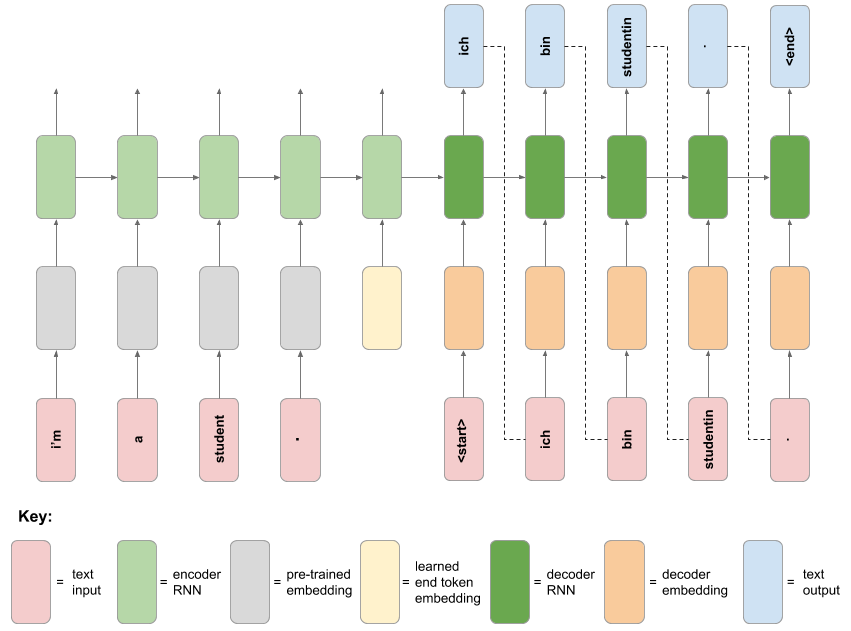

In [ ]:
# Run this cell to download and view a schematic diagram for the neural translation model

!wget -q -O neural_translation_model.png --no-check-certificate "https://docs.google.com/uc?export=download&id=1XsS1VlXoaEo-RbYNilJ9jcscNZvsSPmd"
Image("neural_translation_model.png")

The custom model consists of an encoder RNN and a decoder RNN. The encoder takes words of an English sentence as input, and uses a pre-trained word embedding to embed the words into a 128-dimensional space. To indicate the end of the input sentence, a special end token (in the same 128-dimensional space) is passed in as an input. This token is a TensorFlow Variable that is learned in the training phase (unlike the pre-trained word embedding, which is frozen).

The decoder RNN takes the internal state of the encoder network as its initial state. A start token is passed in as the first input, which is embedded using a learned German word embedding. The decoder RNN then makes a prediction for the next German word, which during inference is then passed in as the following input, and this process is repeated until the special `<end>` token is emitted from the decoder.

## 1. Text preprocessing
* Created separate lists of English and German sentences, and preprocess them using the `preprocess_sentence` function provided for you above.
* Added a special `"<start>"` and `"<end>"` token to the beginning and end of every German sentence.
* Used the Tokenizer class from the `tf.keras.preprocessing.text` module to tokenize the German sentences, ensuring that no character filters are applied. _Hint: use the Tokenizer's "filter" keyword argument._
* Checked 5 randomly chosen examples of (preprocessed) English and German sentence pairs. For the German sentence, print out the text (with start and end tokens) as well as the tokenized sequence.
* Padded the end of the tokenized German sequences with zeros, and batch the complete set of sequences into one numpy array.

In [ ]:
eng_sentence_list = []
ger_sentence_list = []
for line in data_examples:
  values = line.split('\t')
  eng_sentence_list.append(preprocess_sentence(values[0]))
  ger_sentence_list.append("<start> " + preprocess_sentence(values[1]) + " <end>")

print('Number of sentences ', len(eng_sentence_list))
idx =200
print(eng_sentence_list[idx], ' --> ', ger_sentence_list[idx])


Number of sentences  20000
take it .  -->  <start> nimm es . <end>


In [ ]:
import json
def tokenize_sentences(sentence_list):
  tokens = tf.keras.preprocessing.text.Tokenizer(filters='')
  tokens.fit_on_texts(ger_sentence_list)
  config = tokens.get_config()
  
  return tokens, json.loads(config['index_word']), json.loads(config['word_index'])

ger_token, ger_index_word, ger_word_index = tokenize_sentences(ger_sentence_list)
num_ger_tokens = len(ger_index_word)
print('Number of german tokens: ', num_ger_tokens)
print(ger_index_word)
print(ger_word_index)


Number of german tokens:  5743
{'1': '<start>', '2': '<end>', '3': '.', '4': 'ich', '5': 'tom', '6': 'ist', '7': '?', '8': 'sie', '9': '!', '10': 'es', '11': 'das', '12': 'nicht', '13': 'du', '14': 'er', '15': 'bin', '16': 'hat', '17': 'wir', '18': 'habe', '19': 'ein', '20': 'zu', '21': 'mir', '22': 'mich', '23': 'sind', '24': 'war', '25': ',', '26': 'die', '27': 'ihr', '28': 'dich', '29': 'auf', '30': 'kann', '31': 'uns', '32': 'bist', '33': 'hier', '34': 'sich', '35': 'haben', '36': 'an', '37': 'eine', '38': 'was', '39': 'werde', '40': 'einen', '41': 'aus', '42': 'wie', '43': 'wer', '44': 'ihn', '45': 'gehen', '46': 'in', '47': 'der', '48': 'wird', '49': 'gut', '50': 'mein', '51': 'mag', '52': 'dir', '53': 'den', '54': 'sein', '55': 'mit', '56': 'sehr', '57': 'euch', '58': 'hast', '59': 'geht', '60': 'meine', '61': 'liebe', '62': 'jetzt', '63': 'da', '64': 'lass', '65': 'nach', '66': 'will', '67': 'bitte', '68': 'wurde', '69': 'werden', '70': 'so', '71': 'kein', '72': 'noch', '73': '

In [ ]:
import random
random_idx = [random.randint(0, len(ger_sentence_list)) for i in range(5)]

max_sentence_length = 0

ger_sentence_tokenized = []
for i in range(len(ger_sentence_list)):
  words = ger_sentence_list[i].split(' ')
  tokenized = []
  for word in words:
    tokenized.append(ger_word_index[word])
  ger_sentence_tokenized.append(tokenized)
  max_sentence_length = max(max_sentence_length, len(tokenized))

for i in random_idx:
  print(eng_sentence_list[i] + ' --> ' + ger_sentence_list[i])
  print('    --> ' + str(ger_sentence_tokenized[i]))
  print('\n')

tom stared back . --> <start> tom starrte zurueck . <end>
    --> [1, 5, 1211, 147, 3, 2]


tom got confused . --> <start> tom kam ganz durcheinander . <end>
    --> [1, 5, 136, 194, 1301, 3, 2]


you have to rest . --> <start> ihr muesst euch ausruhen . <end>
    --> [1, 27, 601, 57, 437, 3, 2]


do they know ? --> <start> wissen sie das ? <end>
    --> [1, 191, 8, 11, 7, 2]


your time's up . --> <start> deine zeit ist um . <end>
    --> [1, 117, 143, 6, 135, 3, 2]




In [ ]:
ger_sentence_tokenized_padded = tf.keras.preprocessing.sequence.pad_sequences(ger_sentence_tokenized, padding='post') 

In [ ]:
print(type(ger_sentence_tokenized_padded))
print(ger_sentence_tokenized_padded[random_idx])


<class 'numpy.ndarray'>
[[   1    5 1211  147    3    2    0    0    0    0    0    0    0    0]
 [   1    5  136  194 1301    3    2    0    0    0    0    0    0    0]
 [   1   27  601   57  437    3    2    0    0    0    0    0    0    0]
 [   1  191    8   11    7    2    0    0    0    0    0    0    0    0]
 [   1  117  143    6  135    3    2    0    0    0    0    0    0    0]]


## 2. Prepare the data

#### Load the embedding layer
As part of the dataset preproceessing for this project, a pre-trained English word embedding module from TensorFlow Hub is used. The URL for the module is https://tfhub.dev/google/tf2-preview/nnlm-en-dim128-with-normalization/1.

This embedding takes a batch of text tokens in a 1-D tensor of strings as input. It then embeds the separate tokens into a 128-dimensional space. 

The code to load and test the embedding layer is provided for you below.

**NB:** this model can also be used as a sentence embedding module. The module will process each token by removing punctuation and splitting on spaces. It then averages the word embeddings over a sentence to give a single embedding vector. However, we will use it only as a word embedding module, and will pass each word in the input sentence as a separate token.

In [ ]:
# Load embedding module from Tensorflow Hub

embedding_layer = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", 
                                 output_shape=[128], input_shape=[], dtype=tf.string)

In [ ]:
# Test the layer

sample_embedding = embedding_layer(tf.constant(["these", "aren't", "the", "droids", "you're", "looking", "for", "'end'"]))
sample_embedding.shape


TensorShape([8, 128])

Prepare the training and validation Datasets.

* Created a random training and validation set split of the data, reserving e.g. 20% of the data for validation (NB: each English dataset example is a single sentence string, and each German dataset example is a sequence of padded integer tokens).
* Loaded the training and validation sets into a tf.data.Dataset object, passing in a tuple of English and German data for both training and validation sets.
* Created a function to map over the datasets that splits each English sentence at spaces. Appllied this function to both Dataset objects using the map method. _Hint: look at the tf.strings.split function._
* Created a function to map over the datasets that embeds each sequence of English words using the loaded embedding layer/model. Appllied this function to both Dataset objects using the map method.
* Created a function to filter out dataset examples where the English sentence is greater than or equal to than 13 (embedded) tokens in length. Appllied this function to both Dataset objects using the filter method.
* Created a function to map over the datasets that pads each English sequence of embeddings with some distinct padding value before the sequence, so that each sequence is length 13. Appllied this function to both Dataset objects using the map method.
* Batched both training and validation Datasets with a batch size of 16.
* Printed the `element_spec` property for the training and validation Datasets. 
* Used the Dataset `.take(1)` method, print the shape of the English data example from the training Dataset.
* Used the Dataset `.take(1)` method, print the German data example Tensor from the validation Dataset.

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(eng_sentence_list, ger_sentence_tokenized_padded, train_size=0.8, shuffle=True, random_state=12)

In [ ]:
print(len(x_train), y_train.shape)
print(len(x_val), y_val.shape)

16000 (16000, 14)
4000 (4000, 14)


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))


In [ ]:
def split_eng_sentence(x, y):
  return tf.strings.split(x, sep=' '), y

train_dataset = train_dataset.map(split_eng_sentence)
val_dataset = val_dataset.map(split_eng_sentence)

In [ ]:
def embed_eng_sentence(x, y):
  return embedding_layer(x), y

train_dataset = train_dataset.map(embed_eng_sentence)
val_dataset = val_dataset.map(embed_eng_sentence)

In [ ]:
def filter_dataset(x, y):
    return len(x) < 14

train_dataset = train_dataset.filter(filter_dataset)
val_dataset = val_dataset.filter(filter_dataset)

In [ ]:
def pad_eng_sentence(x, y):
  if tf.math.greater(13, tf.shape(x)[0]):
      zero_padding = tf.zeros((tf.math.subtract(13, tf.shape(x)[0]), 128))
      x = tf.concat([zero_padding, x], axis = 0)
  # return tf.shape(x), tf.math.greater(tf.shape(x)[0], 10)
  return x, y

train_dataset_padded = train_dataset.map(pad_eng_sentence)
val_dataset_padded = val_dataset.map(pad_eng_sentence)

In [ ]:
train_dataset_padded = train_dataset_padded.batch(16)
val_dataset_padded = val_dataset_padded.batch(16)


In [ ]:
sample = list(train_dataset_padded.take(1))

In [ ]:

print('English sentence shape ', sample[0][0].shape)
print('German sentence shape ', sample[0][1].shape)

English sentence shape  (16, 13, 128)
German sentence shape  (16, 14)


## 3. Create the custom layer
Create a custom layer to add the learned end token embedding to the encoder model:

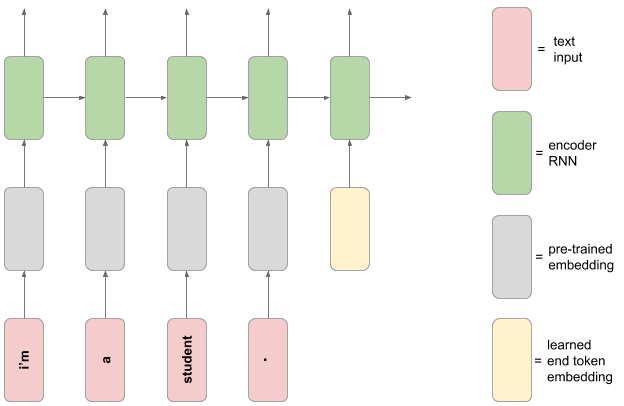

In [ ]:
# Run this cell to download and view a schematic diagram for the encoder model

!wget -q -O neural_translation_model.png --no-check-certificate "https://docs.google.com/uc?export=download&id=1JrtNOzUJDaOWrK4C-xv-4wUuZaI12sQI"
Image("neural_translation_model.png")

Build the custom layer.
* Used layer subclassing, create a custom layer that takes a batch of English data examples from one of the Datasets, and adds a learned embedded ‘end’ token to the end of each sequence. 


In [ ]:
from tensorflow.keras.layers import Layer
class EndVectorLayer(Layer):

  def __init__(self):
    super(EndVectorLayer, self).__init__()
    self.end_vector = self.add_weight(shape=(1, 1, 128), initializer='random_normal')

  def call(self, inputs):
    batch_size = inputs.shape[0]
    tile_specification = tf.constant((inputs.shape[0],1, 1))
    tiled_end_vector = tf.tile(self.end_vector, tile_specification)# (16, 1, 1))
    return tf.concat([inputs, tiled_end_vector], axis=1)


In [ ]:
eng_with_endVec = EndVectorLayer()
sample = next(iter(train_dataset_padded))

print('Before adding the learnable end vector ', sample[0].shape)
print('After passing through the learnable end vector ', eng_with_endVec(sample[0]).shape)

Before adding the learnable end vector  (16, 13, 128)
After passing through the learnable end vector  (16, 14, 128)


## 4. Build the encoder network
The encoder network follows the schematic diagram above. 
* Using the functional API and following specs:
    * The model will take a batch of sequences of embedded English words as input, as given by the Dataset objects.
    * The next layer in the encoder will be the custom layer you created previously, to add a learned end token embedding to the end of the English sequence.
    * This is followed by a Masking layer, with the `mask_value` set to the distinct padding value you used when you padded the English sequences with the Dataset preprocessing above.
    * The final layer is an LSTM layer with 512 units, which also returns the hidden and cell states.
    * The encoder is a multi-output model. There should be two output Tensors of this model: the hidden state and cell states of the LSTM layer. The output of the LSTM layer is unused.
* Using the Dataset `.take(1)` method, extract a batch of English data examples from the training Dataset and test the encoder model by calling it on the English data Tensor, and print the shape of the resulting Tensor outputs.


In [ ]:
from tensorflow.keras.layers import Input, LSTM, Masking
from tensorflow.keras.models import Model

class Encoder(Model):
  def __init__(self):
    super(Encoder, self).__init__()
    self.endVecLayer = EndVectorLayer()
    self.mask = Masking(mask_value=0.0)
    self.lstm_1 = LSTM(units=512, return_state=True)
  
  def call(self, inputs):
    x = self.endVecLayer(inputs)
    x = self.mask(x)
    output, state_h, state_c = self.lstm_1(x)

    return state_h, state_c

encoder_model = Encoder()
encoder_h_state, encoder_c_state = encoder_model(sample[0])
print('Encoder hidden state shape', encoder_h_state.shape)
print('Encoder cell state shape', encoder_c_state.shape)

Encoder hidden state shape (16, 512)
Encoder cell state shape (16, 512)


In [ ]:
print(encoder_model.summary())

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
end_vector_layer_1 (EndVecto multiple                  128       
_________________________________________________________________
masking (Masking)            multiple                  0         
_________________________________________________________________
lstm (LSTM)                  multiple                  1312768   
Total params: 1,312,896
Trainable params: 1,312,896
Non-trainable params: 0
_________________________________________________________________
None


## 5. Build the decoder network
The decoder network follows the schematic diagram below. 

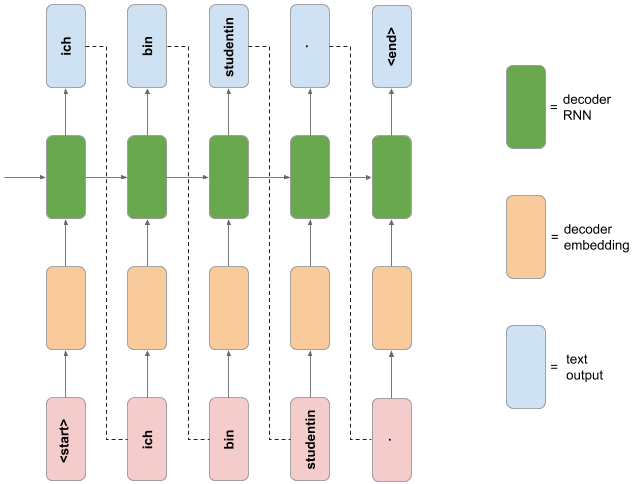

In [ ]:
# Run this cell to download and view a schematic diagram for the decoder model

!wget -q -O neural_translation_model.png --no-check-certificate "https://docs.google.com/uc?export=download&id=1DTeaXD8tA8RjkpVrB2mr9csSBOY4LQiW"
Image("neural_translation_model.png")

Now build the RNN decoder model.
* Using Model subclassing, build the decoder network according to the following spec:
    * The initializer should create the following layers:
        * An Embedding layer with vocabulary size set to the number of unique German tokens, embedding dimension 128, and set to mask zero values in the input.
        * An LSTM layer with 512 units, that returns its hidden and cell states, and also returns sequences.
        * A Dense layer with number of units equal to the number of unique German tokens, and no activation function.
    * The call method should include the usual `inputs` argument, as well as the additional keyword arguments `hidden_state` and `cell_state`. The default value for these keyword arguments should be `None`.
    * The call method should pass the inputs through the Embedding layer, and then through the LSTM layer. If the `hidden_state` and `cell_state` arguments are provided, these should be used for the initial state of the LSTM layer. _Hint: use the_ `initial_state` _keyword argument when calling the LSTM layer on its input._
    * The call method should pass the LSTM output sequence through the Dense layer, and return the resulting Tensor, along with the hidden and cell states of the LSTM layer.
* Using the Dataset `.take(1)` method, extract a batch of English and German data examples from the training Dataset. Test the decoder model by first calling the encoder model on the English data Tensor to get the hidden and cell states, and then call the decoder model on the German data Tensor and hidden and cell states, and print the shape of the resulting decoder Tensor outputs.


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Dense

class Decoder(Model):

  def __init__(self):
    super(Decoder, self).__init__()
    self.embd = Embedding(input_dim=num_ger_tokens+1, output_dim=128, mask_zero=True)
    self.lstm_1 = LSTM(units=512, return_sequences=True, return_state=True)
    self.dense_1 = Dense(units=num_ger_tokens+1)

  def call(self, inputs=None, hidden_state=None, cell_state=None):
    x = self.embd(inputs)
    if hidden_state == None and cell_state==None:
      x, h, c = self.lstm_1(inputs=x)
    else:
      x, h, c = self.lstm_1(inputs=x, initial_state=[hidden_state, cell_state])
    out = self.dense_1(x)

    return out, h, c

In [ ]:
decoder_model = Decoder()
sample = list(train_dataset_padded.take(1))
decoder_output, hidden_state, cell_state = decoder_model(sample[0][1])

print('Output shape --> ', decoder_output.shape)
print('Hidden shape --> ', hidden_state.shape)
print('Cell shape --> ', cell_state.shape)

Output shape -->  (16, 14, 5744)
Hidden shape -->  (16, 512)
Cell shape -->  (16, 512)


In [ ]:
decoder_model.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  735232    
_________________________________________________________________
lstm_1 (LSTM)                multiple                  1312768   
_________________________________________________________________
dense (Dense)                multiple                  2946672   
Total params: 4,994,672
Trainable params: 4,994,672
Non-trainable params: 0
_________________________________________________________________


## 6. Make a custom training loop
Now write a custom training loop to train your custom neural translation model.
* Define a function that takes a Tensor batch of German data (as extracted from the training Dataset), and returns a tuple containing German inputs and outputs for the decoder model (refer to schematic diagram above).
* Define a function that computes the forward and backward pass for your translation model. This function should take an English input, German input and German output as arguments, and should do the following:
    * Pass the English input into the encoder, to get the hidden and cell states of the encoder LSTM.
    * These hidden and cell states are then passed into the decoder, along with the German inputs, which returns a sequence of outputs (the hidden and cell state outputs of the decoder LSTM are unused in this function).
    * The loss should then be computed between the decoder outputs and the German output function argument.
    * The function returns the loss and gradients with respect to the encoder and decoder’s trainable variables.
    * Decorate the function with `@tf.function`
* Define and run a custom training loop for a number of epochs (for you to choose) that does the following:
    * Iterates through the training dataset, and creates decoder inputs and outputs from the German sequences.
    * Updates the parameters of the translation model using the gradients of the function above and an optimizer object.
    * Every epoch, compute the validation loss on a number of batches from the validation and save the epoch training and validation losses.
* Plot the learning curves for loss vs epoch for both training and validation sets.



In [ ]:
def decoder_inp_out(ger_inputs):
  return ger_inputs[:,:-1], ger_inputs[:,1:]


In [ ]:
from tensorflow.keras.utils import to_categorical
import numpy as np

@tf.function
def grads(eng_in, ger_in, loss_obj):
  with tf.GradientTape() as tape:
    ger_inputs, ger_output = decoder_inp_out(ger_in)
    enc_h_state, enc_c_state = encoder_model(eng_in)
    dec_out, _, _ = decoder_model(ger_inputs, enc_h_state, enc_c_state)
    loss_val = loss_obj(ger_output, dec_out)

  grads_val = tape.gradient(loss_val, encoder_model.trainable_variables + decoder_model.trainable_variables)

  return loss_val, grads_val, dec_out
    

In [ ]:

def train_loop():
  epochs = 5

  loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

  train_loss_history = []
  val_loss_history = []

  for epoch in range(epochs):
    epoch_train_avg_loss = tf.keras.metrics.Mean()
    epoch_val_avg_loss = tf.keras.metrics.Mean()

    for eng, ger in tqdm(train_dataset_padded):
      loss_step, grad_step, dec_out = grads(eng, ger, loss_obj)
      optimizer.apply_gradients(zip(grad_step, encoder_model.trainable_variables + decoder_model.trainable_variables))
      epoch_train_avg_loss(loss_step)
    
    for eng_v, ger_v in val_dataset_padded:
      val_loss_step, grad_step, dec_out = grads(eng_v, ger_v, loss_obj)
      epoch_val_avg_loss(loss_step)

    print("Epoch {:03d} Train Loss: {:.3f} Validation Loss: {:.3f} ".format(epoch, 
                     epoch_train_avg_loss.result(), 
                     epoch_val_avg_loss.result()))
    train_loss_history.append(epoch_train_avg_loss.result())
    val_loss_history.append(epoch_val_avg_loss.result())

  return train_loss_history, val_loss_history


In [ ]:
history = train_loop()

1000it [01:31, 10.90it/s]
0it [00:00, ?it/s]

Epoch 000 Train Loss: 5.436 Validation Loss: 5.054 


1000it [01:29, 11.11it/s]
0it [00:00, ?it/s]

Epoch 001 Train Loss: 4.272 Validation Loss: 4.046 


1000it [01:29, 11.12it/s]
0it [00:00, ?it/s]

Epoch 002 Train Loss: 3.391 Validation Loss: 3.173 


1000it [01:29, 11.15it/s]
0it [00:00, ?it/s]

Epoch 003 Train Loss: 2.578 Validation Loss: 2.336 


1000it [01:30, 11.11it/s]


Epoch 004 Train Loss: 1.839 Validation Loss: 1.618 


Text(0, 0.5, 'Loss')

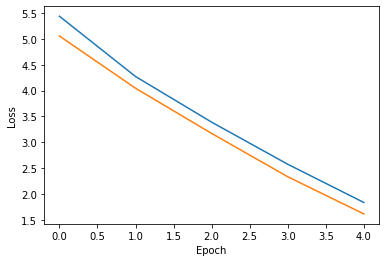

In [ ]:
from matplotlib import pyplot as plt

plt.plot(history[0])
plt.plot(history[1])

plt.xlabel('Epoch')
plt.ylabel('Loss')



## 7. Use the model to translate
Now it's time to the model into practice! Run the translation model for five randomly sampled English sentences from the dataset. For each sentence, the process is as follows:
* Preprocess and embed the English sentence according to the model requirements.
* Pass the embedded sentence through the encoder to get the encoder hidden and cell states.
* Starting with the special  `"<start>"` token, use this token and the final encoder hidden and cell states to get the one-step prediction from the decoder, as well as the decoder’s updated hidden and cell states.
* Create a loop to get the next step prediction and updated hidden and cell states from the decoder, using the most recent hidden and cell states. Terminate the loop when the `"<end>"` token is emitted, or when the sentence has reached a maximum length.
* Decode the output token sequence into German text and print the English text and the model's German translation.

In [ ]:
sample = list(val_dataset_padded.take(1))

eng_sent_sample = sample[0][0]
enc_h, enc_c = encoder_model(eng_sent_sample)

translated_sequence = []
for i in range(16):
  # intializing with start token 
  inp_token = tf.constant([[ger_word_index['<start>']]], dtype=tf.int32)
  ans = [ger_word_index['<start>']]
  dec_h_state = tf.expand_dims(enc_h[i,:], axis=0)
  dec_c_state = tf.expand_dims(enc_c[i,:], axis=0)
  
  while True:
    decoder_output, dec_h_state, dec_c_state = decoder_model(inp_token, 
                                                            dec_h_state, 
                                                            dec_c_state)
    next_token = tf.argmax(decoder_output, axis=2)
    ans.append(next_token.numpy()[0][0])
    inp_token = next_token
  
    if len(ans) > 13 or next_token == ger_word_index['<end>']:
      translated_sequence.append(ans)
      break
  
print(translated_sequence)


[[1, 11, 6, 4446, 3, 2], [1, 4, 18, 60, 4273, 443, 3, 2], [1, 13, 32, 2243, 3, 2], [1, 5, 24, 3727, 3, 2], [1, 134, 4, 1658, 7, 2], [1, 64, 22, 207, 9, 2], [1, 95, 6, 5, 33, 7, 2], [1, 196, 809, 7, 2], [1, 6, 11, 4348, 7, 2], [1, 11, 6, 12, 5, 3, 2], [1, 5, 6, 56, 552, 3, 2], [1, 4, 61, 26, 304, 3, 2], [1, 30, 10, 72, 301, 7, 2], [1, 14, 51, 2039, 3, 2], [1, 10, 6, 428, 3, 2], [1, 4, 261, 1004, 3, 2]]


In [ ]:
translated_sentences = []
for ger_sequence in translated_sequence:
  ger_sentence = []
  for token in ger_sequence:
    ger_sentence.append(ger_index_word[str(token)])
  translated_sentences.append(ger_sentence)

for src_eng, trans_ger in zip(x_val, translated_sentences):
  print(src_eng, ' --> ', ' '.join(trans_ger))

that's confusing .  -->  <start> das ist zweifelhaft . <end>
i found your keys .  -->  <start> ich habe meine rechnungen bezahlt . <end>
you're talkative .  -->  <start> du bist redselig . <end>
tom was ruthless .  -->  <start> tom war wortkarg . <end>
may i cut in ?  -->  <start> darf ich wiederkommen ? <end>
let go of me !  -->  <start> lass mich los ! <end>
why is tom shy ?  -->  <start> warum ist tom hier ? <end>
do ants have ears ?  -->  <start> weinen maenner ? <end>
is this legal ?  -->  <start> ist das erlaubt ? <end>
that's not ok .  -->  <start> das ist nicht tom . <end>
tom is very cute .  -->  <start> tom ist sehr einsam . <end>
i love the woods .  -->  <start> ich liebe die schule . <end>
can it wait ?  -->  <start> kann es noch einmal ? <end>
he loves music .  -->  <start> er mag tiere . <end>
it's improved .  -->  <start> es ist kaputt . <end>
i drink milk .  -->  <start> ich esse obst . <end>
